In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

import UCI_loader
import importlib

In [11]:
# network class
class Network(nn.Module):
    def __init__(self, indim, outdim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,50)
        self.l3 = nn.Linear(50,outdim) 
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x

class quantileNetwork(nn.Module):
    def __init__(self, indim, outdim):
        super(quantileNetwork,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,50)
        self.fc1= nn.Linear(50, outdim)
        self.fc2= nn.Linear(50, outdim)
        self.fc3= nn.Linear(50, outdim)
        self.fc4= nn.Linear(50, outdim)
        self.fc5= nn.Linear(50, outdim)
        self.fc6= nn.Linear(50, outdim)
        self.fc7= nn.Linear(50, outdim)
        self.fc8= nn.Linear(50, outdim)
        self.fc9= nn.Linear(50, outdim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        q1= self.fc1(x)
        q2= self.fc2(x)
        q3= self.fc3(x)
        q4= self.fc4(x)
        q5= self.fc5(x)
        q6= self.fc6(x)
        q7= self.fc7(x)
        q8= self.fc8(x)
        q9= self.fc9(x)
        return [q1,q2,q3,q4,q5,q6,q7,q8,q9]

def tiltedLC(x, y, tau, h):
    e= y-x # errors
    ind= (torch.sign(e)+1)/2 # the division in the log-cosh is only about the origin
    quantFactor= (1-tau)*(1-ind) + tau*ind
    loss= quantFactor*torch.log(torch.cosh(e/h))
    loss= torch.mean(loss)*h
    return loss

def check_loss(x, y, tau): # the x,*args way to pass arguments to this function is an idiom for the scipy.optimize() library y = args[0][0]
    e = y-x
    ind = (torch.sign(-e)+1)/2
    loss = torch.mean(e*(tau-ind))
    return loss

class TiltedLC(nn.Module):
    def __init__(self):
        super(TiltedLC, self).__init__()
    def forward(self, x, y, tau, h):
        return tiltedLC(x, y, tau, h)


class CheckLC(nn.Module):
    def __init__(self):
        super(CheckLC, self).__init__()
    def forward(self, x, y, tau):
        return check_loss(x, y, tau)

class multiQuantileLoss(nn.Module):
    def __init__(self):
        super(multiQuantileLoss, self).__init__()

    def forward(self, x, y, h, loss_list):
        loss1= tiltedLC(x, y, 0.1, h)+ loss_list[0]
        loss2= tiltedLC(x, y, 0.2, h)+ loss_list[1]
        loss3= tiltedLC(x, y, 0.3, h)+ loss_list[2] 
        loss4= tiltedLC(x, y, 0.4, h)+ loss_list[3]
        loss5= tiltedLC(x, y, 0.5, h)+ loss_list[4]
        loss6= tiltedLC(x, y, 0.6, h)+ loss_list[5]
        loss7= tiltedLC(x, y, 0.7, h)+ loss_list[6]
        loss8= tiltedLC(x, y, 0.8, h)+ loss_list[7]
        loss9= tiltedLC(x, y, 0.9, h)+ loss_list[8]
        loss_list= [loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8,loss9]

        return [(loss1+loss2+loss3+loss4+loss5+loss6+loss7+loss8+loss9)/9, loss_list]

# Getting the data
importlib.reload(UCI_loader)
data_energy= UCI_loader.UCIDatasets("energy") 
data_yacht= UCI_loader.UCIDatasets("yacht") 
train_data_energy= data_energy.get_split()
train_data_yacht= data_yacht.get_split()
# test_data= data.get_split(train=False)


# instantiating the network for training on this dataset
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model11= quantileNetwork(indim=8,outdim=2).to(device=device)
model12= Network(indim=8,outdim=2).to(device=device)
model21= Network(indim=6,outdim=1).to(device=device)
model22= Network(indim=6,outdim=1).to(device=device)
tau= 0.5
h= 0.2

criterion1= multiQuantileLoss()
criterion2= CheckLC()
optimizer11= optim.Adam(model11.parameters())
optimizer12= optim.Adam(model12.parameters())
optimizer21= optim.Adam(model21.parameters())
optimizer22= optim.Adam(model22.parameters())

In [13]:
# training using the log-cosh
# the fundamental training loop
 # instantiating the DataLoader
trainloader = torch.utils.data.DataLoader(
                    train_data_energy, # a torch Dataset object
                    batch_size=16,
                    shuffle=True)
ls_a= []
N_EPOCHS= 100
for epoch in range(N_EPOCHS):
    epoch_loss1 = 0.0
    for inputs, labels in trainloader: 
        inputs = inputs.to(device) 
        labels = labels.to(device)
        labels= torch.tile(labels, (1,9))
        optimizer11.zero_grad() 
        outputs = model11(inputs) 
        outputs= torch.cat(outputs, dim=1)
        loss1= criterion1(outputs, labels, tau, h) 
        loss1.backward() 
        optimizer11.step() 
        epoch_loss1+= loss1.item() 
    ls_a.append((epoch_loss1/len(trainloader)))
    print("Epoch: {} Loss: {}".format(epoch,
           epoch_loss1/len(trainloader)))

Epoch: 0 Loss: 0.003824852327604524
Epoch: 1 Loss: 0.003578526129951404
Epoch: 2 Loss: 0.00356927532332272
Epoch: 3 Loss: 0.003638963375124149
Epoch: 4 Loss: 0.003414542845513841
Epoch: 5 Loss: 0.0033303172848801214
Epoch: 6 Loss: 0.003742950797790069
Epoch: 7 Loss: 0.0038450750474691054
Epoch: 8 Loss: 0.0034282018869734284
Epoch: 9 Loss: 0.0034730810809626496
Epoch: 10 Loss: 0.0034697567647196015
Epoch: 11 Loss: 0.0034038644437466496
Epoch: 12 Loss: 0.0033925576585302638
Epoch: 13 Loss: 0.0036950069215064022
Epoch: 14 Loss: 0.0037362866939722812
Epoch: 15 Loss: 0.003641471232351085
Epoch: 16 Loss: 0.0032987757136156274
Epoch: 17 Loss: 0.0035080933991015295
Epoch: 18 Loss: 0.0038561057299375534
Epoch: 19 Loss: 0.00390316645974632
Epoch: 20 Loss: 0.004083288849373771
Epoch: 21 Loss: 0.003550513560185209
Epoch: 22 Loss: 0.0028868759598646484


KeyboardInterrupt: 

In [ ]:
# training using the check
ls_b= []
for epoch in range(N_EPOCHS):
    epoch_loss2 = 0.0
    for inputs, labels in trainloader:
        inputs = inputs.to(device) 
        labels = labels.to(device)
        optimizer12.zero_grad() 
        outputs = model12(inputs) 
        loss2= criterion2(outputs, labels, tau)
        loss2.backward() 
        optimizer12.step() 
        epoch_loss2+= loss2.item() 
    ls_b.append(epoch_loss2/len(trainloader))
    print("Epoch: {} Loss: {}".format(epoch,
           epoch_loss2/len(trainloader)))

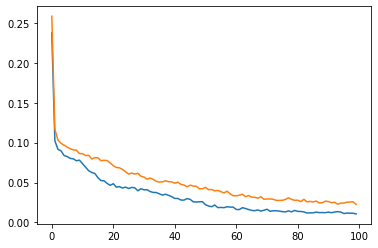

In [16]:
plt.plot(range(N_EPOCHS), ls_a) # log-cosh
plt.plot(range(N_EPOCHS), ls_b) # check

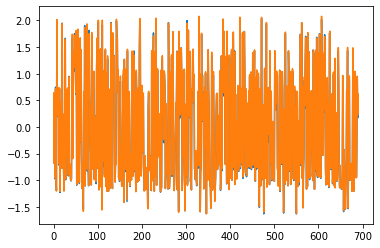

In [11]:
op_1= []
op_2= []

# creating an iterable through each element of the dataset
pltLoad= torch.utils.data.DataLoader(
                    # torch.utils.data.RandomSampler(train_data_energy, num_samples=20),
                    train_data_energy,
                    batch_size=1,
                    shuffle=True)

for inputs, labels in pltLoad:
    inputs = inputs.to(device) 
    labels = labels.to(device)
    outputs1 = model11(inputs) 
    outputs2= model12(inputs)
    op_1.append(outputs1[0][0])
    op_2.append(outputs2[0][0])

plt.plot(range(len(pltLoad)), op_1) # plot of one of the responses for the log-cosh  
plt.plot(range(len(pltLoad)), op_2) # plot of one of the responses for the check